# 2D Wave
This is an extension of the previous notebook, where we extend the differential equation problem to 2D. Now, instead of speed, we have a vector for the speed, denoted $(u,v)$ for the speed in $(x,y)$.

First, all our imports...

In [1]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  
import time
import sys
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

# Set the seed
np.random.seed(0)

## Initialise Model
As before, we will set up relevant functions for initial conditions and iterating the wave through in time. We now have an $(x,y)$-grid, where the initial condition is a cosine bell between four points specified (`alpha_x`, `beta_x`, `alpha_y`, `beta_y`).

In [2]:
def initialise_wave(nx, dx, ny, dy, alpha_x, beta_x, alpha_y, beta_y):
    """ Cos wave"""
    x = np.linspace(0.,2.,nx)
    y = np.linspace(0.,2.,ny)
    x, y = np.meshgrid(x,y)
    bell = lambda x,y : 0.5 * (1 - np.cos(2.*np.pi*(x-alpha_x)/(beta_x - alpha_x))) * \
        (1 - np.cos(2.*np.pi*(y-alpha_y)/(beta_y - alpha_y)) )
    
    h = np.where((x<beta_x) & (x>=alpha_x) & (y<beta_y) & (y>=alpha_y), bell(x,y), 0.)
    return torch.tensor(h, dtype=torch.double)

Lets check how this looks using a contour plot:

<Figure size 432x288 with 0 Axes>

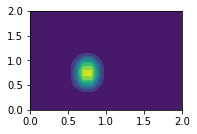

In [3]:
nx, ny = 21, 21
dx, dy = 2./(nx-1), 2./(ny-1)
plt.clf()
fig = plt.figure()
x = np.linspace(0., 2., nx)
y = np.linspace(0., 2., ny)
x, y = np.meshgrid(x, y)
init_h = initialise_wave(nx, dx, ny, dy,
                         alpha_x=0.5, beta_x=1.0, alpha_y=0.25, beta_y=1.25)
ax = fig.add_subplot(2, 2, 1)
ax.contourf(x, y, init_h)

Then we set up the `advect` function, using finite difference scheme in 2D for speeds in both the $x$ and $y$ direction.

In [4]:
def advect(h, u, v, nt, dt, nx, dx, ny, dy):
    """ Returns wave height after nt iterations, given initial height h
    """
    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(h.shape, dtype=torch.double)
    for n in range(nt): 
        # Boundary conditions
        hn[0,:] = h[0,:]
        hn[:,0] = h[:,0]
        hn[-1,:] = h[-1,:]
        hn[:,-1] = h[:,-1]
        # Finite difference equation
        hn[1:,1:] = h[1:,1:] - u * torch.tensor([dt / dx], dtype=torch.double) * (h[1:,1:] - h[0:-1,1:]) \
            - v * torch.tensor([dt / dy], dtype=torch.double) * (h[1:,1:] - h[1:,0:-1])
        # set h to hn for next iteration
        h = hn
    return h

Now we define the model which samples from the latent variables `u` and `v`, given the prior provided by the user (for the mean of a Normal distribution, with a fixed standard deviation of 0.25). 

In [25]:
pyro.clear_param_store()

def model(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy, alpha_x=0.5, beta_x=1.0, alpha_y=0.25, beta_y=1.25):
    """Returns latent random variables u and v and the wave height h
    Args:
    u_prior, v_prior = mean of normal distribution for prior for u and v
    (both torch.tensor, dtype=torch.double)
    observed_inds = list of tuples for (x,y) indices observed
    nt, dt = number of timesteps (int), size of timestep (float)
    nx, dx, ny, dy = number of grid points in x/y (int), width of grid points in x/y (float)"""
    
    # 1) Sample random variables
    u = pyro.sample("u", dist.Normal(u_prior, torch.tensor([0.25], dtype=torch.double)))
    v = pyro.sample("v", dist.Normal(v_prior, torch.tensor([0.25], dtype=torch.double)))
    
    # 2) Initial conditions
    h0 = initialise_wave(nx, dx, ny, dy, alpha_x, beta_x, alpha_y, beta_y)
    
    # 3) Advect wave
    pred_h = advect(h0, u, v, nt, dt, nx, dx, ny, dy)
    
    # 4) Observe  
    obs_h = pred_h.clone()
    for ix in pyro.plate("x_axis", nx):
        # each point on the x-axis is conditionally independent given the speed 
        for iy in pyro.plate("y_axis_{}".format(ix), ny):  
            if (ix, iy) in observed_inds:
                obs_h[ix, iy] = pyro.sample("h_{},{}".format(str(ix), str(iy)),
                                            dist.Normal(pred_h[ix, iy],
                                                        torch.tensor([0.01], 
                                                                     dtype=torch.double)))     

    
    return(u, v, obs_h)


Let's check how the output varies if we sample multiple times.
Want to learn $$P(u, v|h) \sim \, ?$$

In [26]:
# Set up parameters
u_prior = torch.tensor([0.5], dtype=torch.double)
v_prior = torch.tensor([0.5], dtype=torch.double)
nx = 21
ny = 21
nt = 500
dt = 0.001
dx = 2./(nx-1)
dy = 2./(ny-1)

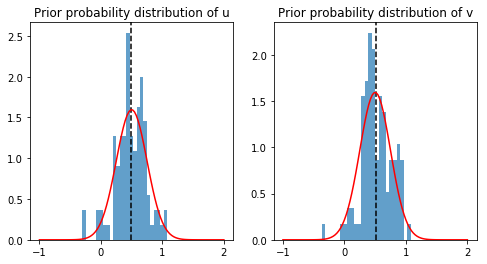

In [27]:
u_uncond, v_uncond = [], []
fig = plt.figure(figsize=(8, 4))
ax0 = plt.subplot2grid((1, 2), (0, 0))

for i in range(100):
    u, v, h = model(u_prior, v_prior, [], nt, dt, 
          nx, dx, ny, dy)
    u_uncond.append(u)
    v_uncond.append(v)

plt.title("Wave after nt timesteps")
# Plot probability distribution of speed
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(u_uncond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(u_uncond), c="k", ls="--");
x = np.linspace(-1., 2., 100);
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-u_prior.numpy())**2/(2*0.25**2))
ax1.plot(x,f,color="red")
plt.title("Prior probability distribution of u");
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(v_uncond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(v_uncond), c="k", ls="--");
x = np.linspace(-1., 2., 100);
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-v_prior.numpy())**2/(2*0.25**2))
ax1.plot(x,f,color="red")
plt.title("Prior probability distribution of v");

As before, we will pick an observation speed. I will choose `u_obs=0.7` and `v_obs=0.8`. Then, we calculate the observed height field according to the advection function (note, this is different from the 1D version of the notebook, where we assumed the observed height field came from the <b>exact</b> analytical equation for the height field.

In [28]:
u_obs = torch.tensor([0.7], dtype=torch.double)
v_obs = torch.tensor([0.8],dtype=torch.double)
# Initial conditions
h0 = initialise_wave(nx, dx, ny, dy, alpha_x=0.5, beta_x=1.0, alpha_y=0.25, beta_y=1.25)
# Observed field
full_observed_h = advect(h0, u_obs, v_obs, nt, dt, nx, dx, ny, dy)

# Pick some random points along x and y axis that we observe
observed_x = np.random.choice(nx, size=int(nx*ny/3), replace=True)
observed_y = np.random.choice(ny, size=int(nx*ny/3), replace=True)

# Put into data dictionary with named labels
data = {}
observed_inds = []
for i in range(len(observed_x)):
    ix, iy  = observed_x[i], observed_y[i]
    observed_inds.append((ix, iy))
    data["h_{},{}".format(str(ix), str(iy))] = full_observed_h[ix, iy]
    
print(data.keys())

dict_keys(['h_14,3', 'h_0,6', 'h_19,20', 'h_8,7', 'h_7,19', 'h_13,0', 'h_17,5', 'h_20,11', 'h_0,9', 'h_11,19', 'h_4,7', 'h_0,5', 'h_10,8', 'h_14,11', 'h_20,14', 'h_18,0', 'h_4,8', 'h_3,19', 'h_19,6', 'h_7,10', 'h_8,19', 'h_13,2', 'h_5,0', 'h_0,19', 'h_8,14', 'h_15,0', 'h_15,19', 'h_11,6', 'h_4,1', 'h_7,12', 'h_13,18', 'h_10,13', 'h_20,9', 'h_14,4', 'h_17,17', 'h_19,3', 'h_3,2', 'h_9,20', 'h_18,13', 'h_2,15', 'h_19,4', 'h_11,9', 'h_18,4', 'h_13,17', 'h_1,18', 'h_6,13', 'h_16,2', 'h_16,3', 'h_3,9', 'h_17,12', 'h_10,15', 'h_9,2', 'h_12,19', 'h_13,6', 'h_6,14', 'h_6,16', 'h_7,15', 'h_8,8', 'h_16,11', 'h_15,13', 'h_3,6', 'h_17,15', 'h_7,9', 'h_20,6', 'h_2,11', 'h_16,18', 'h_18,7', 'h_13,1', 'h_4,9', 'h_4,2', 'h_12,18', 'h_17,14', 'h_20,5', 'h_1,4', 'h_5,18', 'h_1,14', 'h_19,18', 'h_19,1', 'h_9,0', 'h_17,9', 'h_9,16', 'h_0,2', 'h_19,8', 'h_4,19', 'h_17,10', 'h_20,16', 'h_16,1', 'h_3,0', 'h_10,5', 'h_1,2', 'h_20,15', 'h_4,3', 'h_4,14', 'h_16,5', 'h_10,6', 'h_13,20', 'h_8,6', 'h_6,2', 'h_9,6',

Condition on this data, as before, in just one line:

In [29]:
conditioned_model = pyro.condition(model, data=data)
conditioned_model

<function pyro.poutine.messenger.Messenger.__call__.<locals>._wraps(*args, **kwargs)>

Let's check the probability distributions for $u$ and $v$ in the conditioned model. They should be the same as before. 

Text(0.5,1,'v')

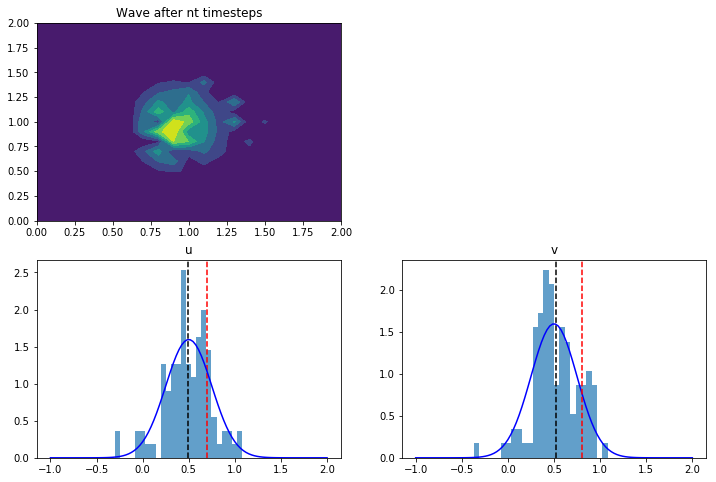

In [31]:
# Check this gives conditioned values fixed
u_cond, v_cond  = [], []
fig = plt.figure(figsize=(12, 8))
ax0 = plt.subplot2grid((2, 2), (0, 0))

# Plot one example to show the observed h differs from the rest of the model output
x = np.linspace(0., 2., nx)
y = np.linspace(0., 2., ny)
x, y = np.meshgrid(x, y)
u, v, h = conditioned_model(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy)
ax0.contourf(x, y, h.detach().numpy())

for i in range(100):
    u, v, h = conditioned_model(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy)
    u_cond.append(u.item())
    v_cond.append(v.item())
    

plt.title("Wave after nt timesteps")
# Plot probability distribution of speed
ax1 = plt.subplot2grid((2, 2), (1, 0));
ax1.hist(u_uncond, 25, density=True, alpha=0.7, label="Prior Distribution")
ax1.axvline(np.mean(u_uncond), c="k", ls="--")
ax1.axvline(u_obs, c="red", ls="--", label="True observed")
x = np.linspace(-1., 2., 100)
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-u_prior.numpy())**2/(2*0.25**2))
ax1.plot(x,f,color="blue")
plt.title("u")
ax1 = plt.subplot2grid((2, 2), (1, 1));
ax1.hist(v_uncond, 25, density=True, alpha=0.7, label="Prior Distribution")
ax1.axvline(np.mean(v_uncond), c="k", ls="--")
x = np.linspace(-1., 2., 100)
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-v_prior.numpy())**2/(2*0.25**2))
ax1.plot(x,f,color="blue")
ax1.axvline(v_obs, c="red", ls="--", label="True observed")
plt.title("v")

This conditioned contour plot looks strange- because some points (the observed ones) are constrained, but the remaining points are not. This will be fixed when we do inference to constrain the latent variables $u $ and $v$. Now create the guide for the latent variables, with parameters that should move us towards observed values of the wave.

In [32]:
from torch.distributions import constraints

def parameterised_guide(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy):
    # want to infer speed, and h_i at all values that we don't know them at
    a = pyro.param("a", u_prior)
    b = pyro.param("b", torch.tensor([0.25], dtype=torch.double), 
                   constraint=constraints.positive)

    c = pyro.param("c", v_prior)
    d = pyro.param("d", torch.tensor([0.25], dtype=torch.double), 
                   constraint=constraints.positive)
    
    u = pyro.sample("u", dist.Normal(a,b))
    v = pyro.sample("v", dist.Normal(c,d))
    
    return(u, v)


In [33]:
# Plotting function
def plot_wave(h0, u, v, nt, dt, nx, dx, ny, dy):
    plt.clf()
    fig = plt.figure()
    x = np.linspace(0., 2., nx)
    y = np.linspace(0., 2., ny)
    x, y = np.meshgrid(x, y)
    h = advect(h0, u, v, nt, dt, nx, dx, ny, dy)
    ax = fig.add_subplot(2, 2, 1)
    ax.contourf(x, y, h)
    plt.show()


<Figure size 864x288 with 0 Axes>

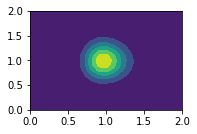

In [34]:
# Plot the prior guide before optimisation
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
plot_wave(h0, u_prior.item(), v_prior.item(), nt, dt, nx, dx, ny, dy)

['a', 'b', 'c', 'd']
Iteration 0


<Figure size 432x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

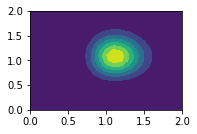

0.7018574715467002 0.8114820588582498


KeyboardInterrupt: 

In [36]:
%%time
from pyro.optim import Adam
pyro.clear_param_store()
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_model, 
                     guide=parameterised_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 6000

# Save all parameters and losses
svi.step(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy)
param_names = list(pyro.get_param_store().get_all_param_names())
print(param_names)

params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)

# Iterate
for t in range(num_steps):
    losses[t] = svi.step(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy)
    params[t,:] = [pyro.param(param_names[i]).item() for i in range(len(param_names))]
    
    if (t%100==0.):
        print('Iteration {}'.format(str(t)))
        plt.clf();
        fig = plt.figure(figsize=(8, 4));
        u_mean = pyro.param("a").item()
        v_mean = pyro.param("c").item()
        plot_wave(h0, u_mean, v_mean, nt, dt, nx, dx, ny, dy)
        print(u_mean, v_mean)


Plot the ELBO and parameters.

718


Text(0,0.5,'loss')

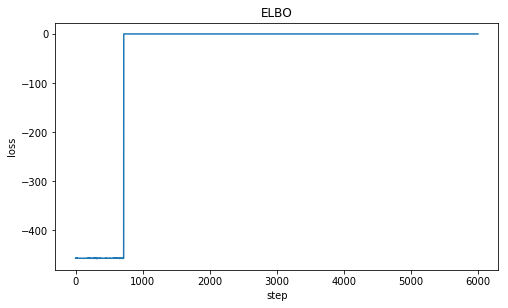

In [15]:
print(t)       
fig = plt.figure(figsize=(10, 10));
ax = plt.subplot2grid((2, 5), (1, 0), colspan=4)
ax.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

a =  0.5
b =  0.22596237940863617
c =  0.5
d =  0.23460578204843172


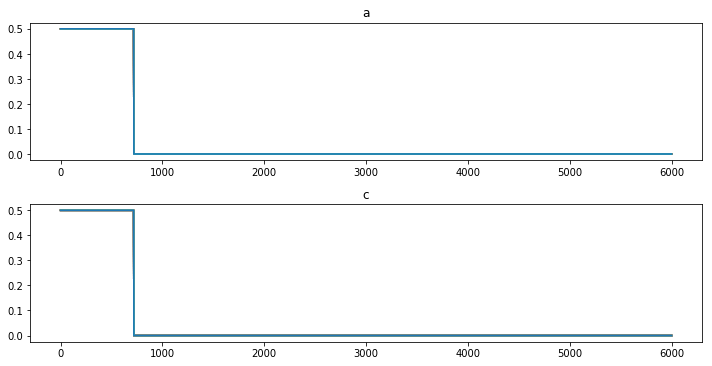

In [16]:
print("a = ", pyro.param("a").item())
print("b = ", pyro.param("b").item())
print("c = ", pyro.param("c").item())
print("d = ", pyro.param("d").item())


fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((4, 1), (0, 0));
for i in range(nx):
    ax1.plot(params[:,0])
plt.title('a');

ax2 = plt.subplot2grid((4, 1), (1, 0));
for i in range(nx):
    ax2.plot(params[:,2])
plt.title('c');

plt.tight_layout();

In [17]:
'u', u_obs.item(),  pyro.param("a").item(), 'v', v_obs, pyro.param("c").item()



('u', 0.7, 0.5, 'v', tensor([0.8000], dtype=torch.float64), 0.5)

In [18]:
u_v_guide = [parameterised_guide(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy)  for _ in range(100)]

In [19]:
u_guide, v_guide = zip(*u_v_guide)
u_guide, v_guide = [u.item() for u in u_guide], [v.item() for v in v_guide]

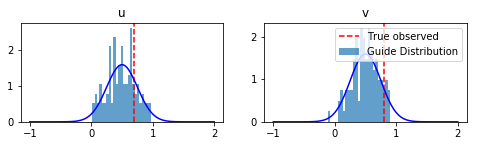

In [20]:
# Plot posterior distribution
plt.figure(figsize=(8, 4))
ax1 = plt.subplot2grid((2, 2), (1, 0));
ax1.hist(u_guide, 25, density=True, alpha=0.7, label="Guide Distribution")
ax1.axvline(u_obs, c="red", ls="--", label="True observed")
x = np.linspace(-1., 2., 100)
u_mean = pyro.param("a").item()
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-u_mean)**2/(2*0.25**2))
ax1.plot(x,f,color="blue")
plt.title("u")

ax1 = plt.subplot2grid((2, 2), (1, 1));
ax1.hist(v_guide, 25, density=True, alpha=0.7, label="Guide Distribution")
ax1.axvline(v_obs, c="red", ls="--", label="True observed")
x = np.linspace(-1., 2., 100)
v_mean = pyro.param("c").item()
f = 1./(0.25*np.sqrt(2*np.pi))*np.exp(-(x-v_mean)**2/(2*0.25**2))
ax1.plot(x,f,color="blue")
plt.title("v")
plt.legend();

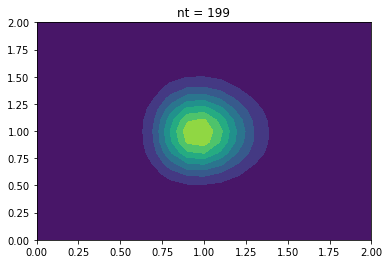

In [21]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()

# Initialise and plot
def init():
    ax.set_xlim(0., 2.)
    ax.set_ylim(0., 2.)

def update(frame):
    u = params[frame,0]
    v = params[frame,2]
    h = advect(h0, u, v, nt, dt, nx, dx, ny, dy)
    plt.clf()
    plt.title('nt = {}'.format(frame))
    x = np.linspace(0., 2., nx)
    y = np.linspace(0., 2., ny)
    x, y = np.meshgrid(x, y)
    plt.contourf(x, y, h, levels=np.linspace(0.,1.,10))
    

ani = FuncAnimation(fig, update, frames=range(0,200,1), interval=100,
                    init_func=init)
HTML(ani.to_jshtml())

## MCMC

In [22]:
%%time
import pyro.infer.mcmc
hmc_kernel = pyro.infer.mcmc.HMC(conditioned_model,
                                   adapt_step_size=True)
mcmc = pyro.infer.mcmc.MCMC(hmc_kernel,
                            num_samples=1,
                            warmup_steps=1)
mcmc_run = mcmc.run(u_prior, v_prior, observed_inds, nt, dt, 
          nx, dx, ny, dy)

Sample: 100%|██████████| 2/2 [00:11<00:00,  6.97s/it, step size=1.17e+00, acc. rate=0.000]

CPU times: user 11.6 s, sys: 184 ms, total: 11.8 s
Wall time: 11.9 s
